# Imports

In [33]:
import os
import shutil
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Data Loading Function

In [34]:
def extract_apple_class(source_dir, apple_only_path):
    """
    Extract only apple images from the given directory into a new directory.
    """
    os.makedirs(apple_only_path, exist_ok=True)
    
    all_apples = []
    
    for img_name in os.listdir(source_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            src = os.path.join(source_dir, img_name)
            dst = os.path.join(apple_only_path, img_name)
            shutil.copy(src, dst)
            all_apples.append(dst)
    
    print(f"Extracted {len(all_apples)} apple images")
    return all_apples

# path to Apple folder
SOURCE_DIR = '/kaggle/input/fruit-recognition/Apple/Apple A'
APPLE_ONLY_PATH = '/kaggle/working/apple_images'

# Extracting the apple images
apple_images = extract_apple_class(SOURCE_DIR, APPLE_ONLY_PATH)

# Splitting into train/validation
if len(apple_images) > 0:
    X_train, X_valid = train_test_split(apple_images, test_size=0.2, random_state=42)
    print(f"Training set: {len(X_train)} images")
    print(f"Validation set: {len(X_valid)} images")
else:
    print("No apple images found. Please check your SOURCE_DIR path.")

Extracted 692 apple images
Training set: 553 images
Validation set: 139 images


# Loading the Apple Data

In [35]:
input_size = 64 * 64 * 3
latent_dimension = 128

In [36]:
def load_images(image_paths, target_size=(64, 64)):
    data = []
    for img_path in image_paths:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        data.append(img_array)
    return np.array(data)

# Creating the Noise Function

In [37]:
def add_noise(images, noise_factor=0.1):
    # we will be adding Guassian noise to the images.
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0.0, 1.0)
    return noisy_images

# Reshaping, Normalizing Adding Noise to the Data

In [41]:
X_train_arr = load_images(X_train, target_size=(64, 64))
X_valid_arr = load_images(X_valid, target_size=(64, 64))

X_train_clean = X_train_arr.reshape(-1, input_size) / 255.0
X_valid_clean = X_valid_arr.reshape(-1, input_size) / 255.0

# Noisy images as (inputs) 
X_train_noisy = add_noise(X_train_clean, noise_factor=0.2)
X_valid_noisy = add_noise(X_valid_clean, noise_factor=0.2)

# Visualizing Noise levels.

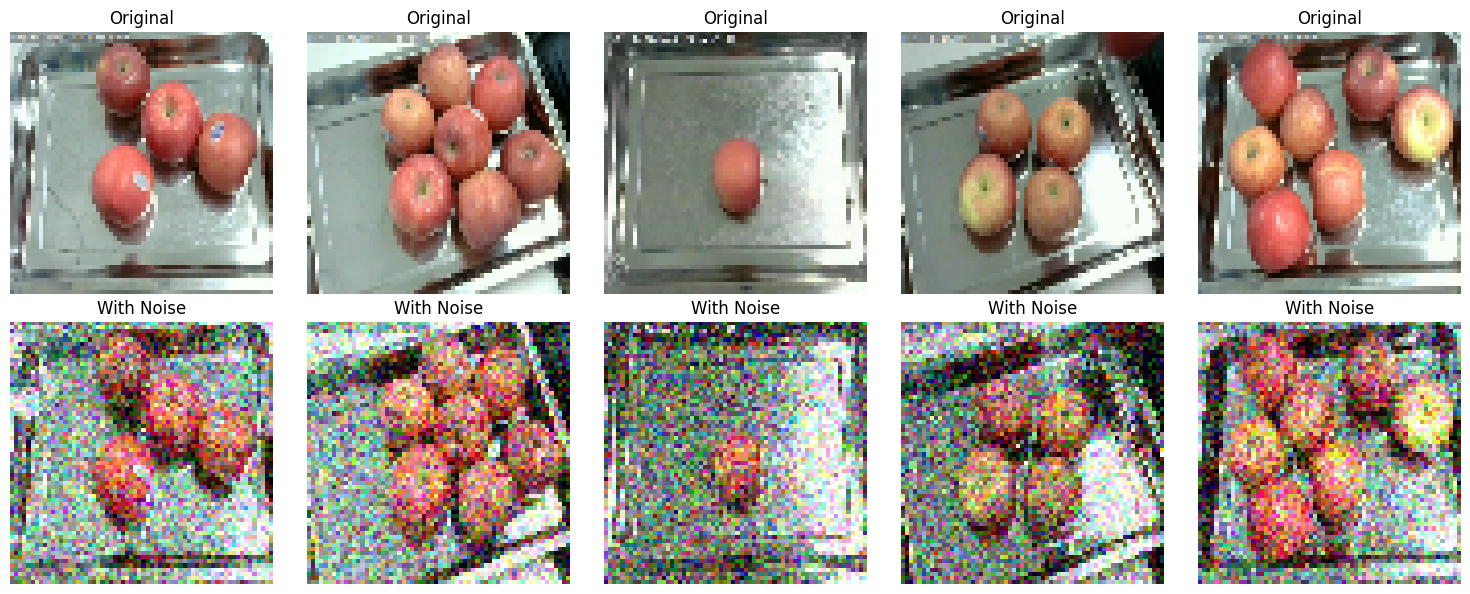

In [42]:
def visualize_noise_levels(clean_images, noisy_images, n_images=5):
    """
    Simple visualization to compare original vs noisy images
    """
    # Reshaping for display
    clean_reshaped = clean_images[:n_images].reshape(-1, 64, 64, 3)
    noisy_reshaped = noisy_images[:n_images].reshape(-1, 64, 64, 3)
    
    fig, axes = plt.subplots(2, n_images, figsize=(15, 6))
    
    for i in range(n_images):
        # the Original clean image
        axes[0, i].imshow(clean_reshaped[i])
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        # the noisy image
        axes[1, i].imshow(np.clip(noisy_reshaped[i], 0, 1))
        axes[1, i].set_title('With Noise')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

X_train_clean = X_train_arr.reshape(-1, input_size) / 255.0
X_train_noisy = add_noise(X_train_clean, noise_factor=0.2)
visualize_noise_levels(X_train_clean, X_train_noisy)

# Building the Autoencoder Architecture

In [43]:
encoder = keras.Sequential([
    layers.Dense(2048, activation='relu', input_shape=(input_size,)),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(256, activation=None),
], name='encoder')

decoder = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(256,)),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(2048, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(input_size, activation='sigmoid'),
], name='decoder')

autoencoder = keras.Sequential([encoder, decoder], name='autoencoder')

In [44]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [45]:
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Sequential)            │ (None, 256)            │    27,936,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (None, 12288)          │    27,948,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,885,056 (213.18 MB)

 Trainable params: 55,870,720 (213.13 MB)

 Non-trainable params: 14,336 (56.00 KB)

# Compiling the Autoencoder

In [46]:
history = autoencoder.fit(
    X_train_noisy, X_train_clean,
    epochs=50,
    batch_size=32,
    validation_data=(X_valid_noisy, X_valid_clean),
    verbose=1
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 788ms/step - loss: 0.0559 - mae: 0.1813 - val_loss: 0.3351 - val_mae: 0.5214
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 733ms/step - loss: 0.0315 - mae: 0.1278 - val_loss: 0.3497 - val_mae: 0.5374
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 761ms/step - loss: 0.0285 - mae: 0.1197 - val_loss: 0.3561 - val_mae: 0.5423
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 736ms/step - loss: 0.0268 - mae: 0.1136 - val_loss: 0.3039 - val_mae: 0.4866
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 738ms/step - loss: 0.0235 - mae: 0.1042 - val_loss: 0.3002 - val_mae: 0.4797
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 771ms/step - loss: 0.0228 - mae: 0.1001 - val_loss: 0.2630 - val_mae: 0.4375
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 751ms/step - loss: 0.0236 - mae: 0.1052 - val_loss: 0.1769 - val_mae: 0.3427
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 768ms/step - loss: 0.0219 - mae: 0.1001 - val_loss: 0.0685 - val_mae: 0.1960
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 740ms/

# Visualizing Training

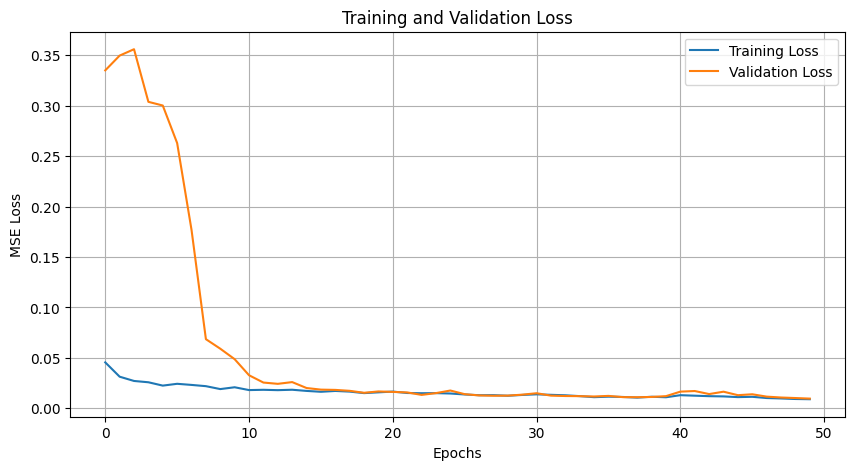

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


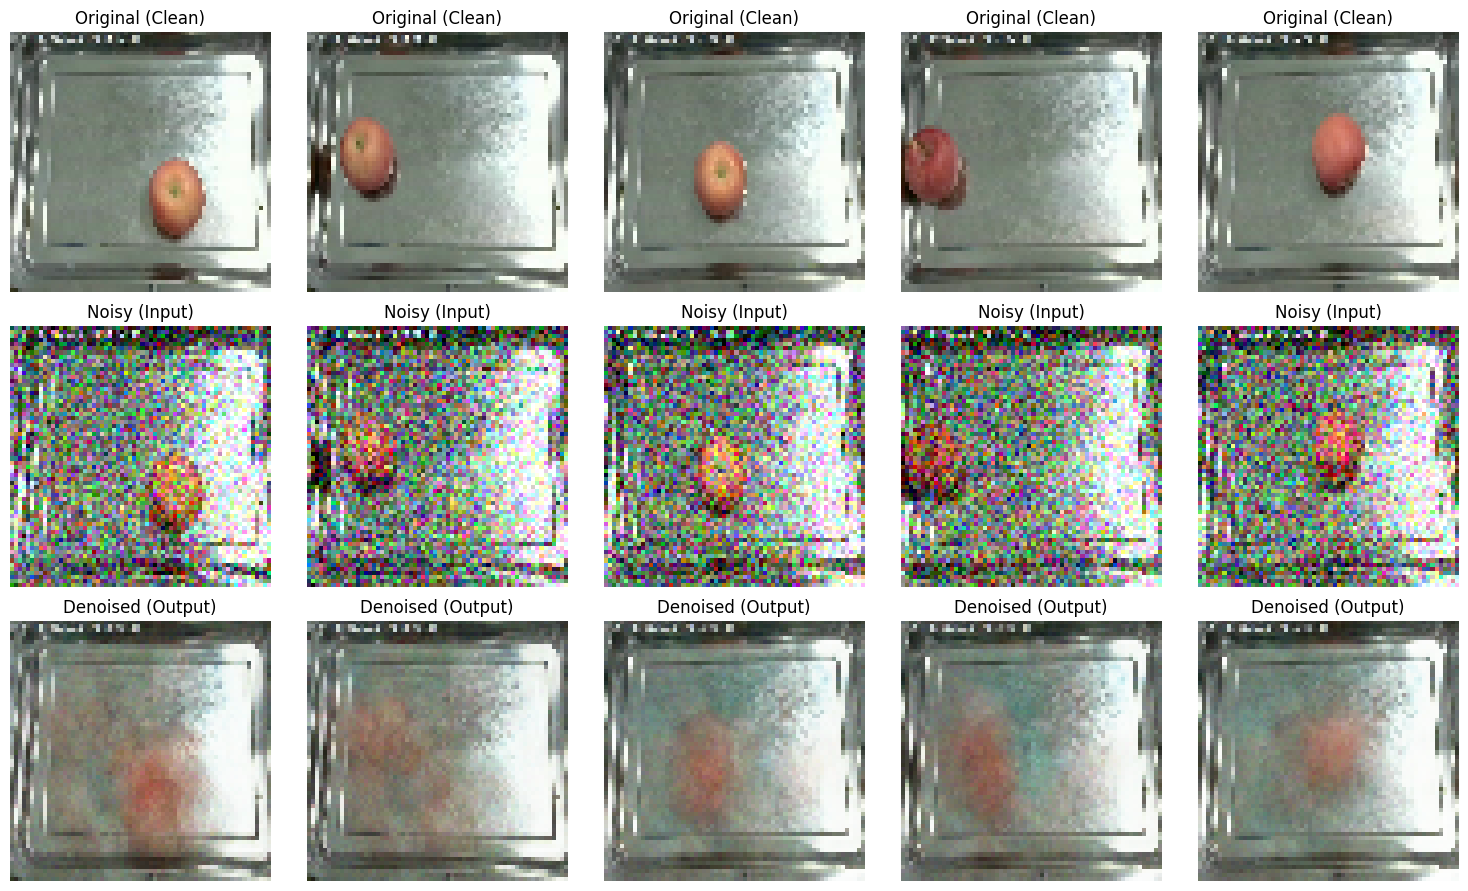

In [48]:
def visualize_denoising(autoencoder, X_valid_clean, X_valid_noisy, n_images=5):
    """
    Visualize original, noisy, and reconstructed images
    """
    # Getting reconstructions from noisy inputs
    reconstructed = autoencoder.predict(X_valid_noisy[:n_images])
    
    # Reshaping back to image format
    reconstructed = reconstructed.reshape(-1, 64, 64, 3)
    X_valid_clean_reshaped = X_valid_clean[:n_images].reshape(-1, 64, 64, 3)
    X_valid_noisy_reshaped = X_valid_noisy[:n_images].reshape(-1, 64, 64, 3)
    
    # Plot comparisons
    fig, axes = plt.subplots(3, n_images, figsize=(15, 9))
    
    for i in range(n_images):
        # Original clean images
        axes[0, i].imshow(X_valid_clean_reshaped[i])
        axes[0, i].set_title('Original (Clean)')
        axes[0, i].axis('off')
        
        # Noisy images
        axes[1, i].imshow(X_valid_noisy_reshaped[i])
        axes[1, i].set_title('Noisy (Input)')
        axes[1, i].axis('off')
        
        # Reconstructed images
        axes[2, i].imshow(np.clip(reconstructed[i], 0, 1))
        axes[2, i].set_title('Denoised (Output)')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()


visualize_denoising(autoencoder, X_valid_clean, X_valid_noisy)